# Bike Sharing Demand

From the [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand).

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import math
import sys
sys.path.append("/home/paperspace/fastai")

In [3]:
from datetime import datetime
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

from fastai.structured import *
from fastai.column_data import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy m

## Import and format data

In [4]:
!ls

bike-sharing-demand.ipynb  sampleSubmission.csv  tmp
models			   test.csv		 train.csv


In [5]:
train = pd.read_csv('train.csv', sep = ',')
train.shape

(10886, 12)

In [6]:
test = pd.read_csv('test.csv', sep = ',')
test.shape

(6493, 9)

In [7]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [8]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [9]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
train.datetime.max()

'2012-12-19 23:00:00'

In [11]:
train.datetime = pd.to_datetime(train.datetime)
test.datetime = pd.to_datetime(test.datetime)

train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [12]:
def add_datetime_fields(df):
    df1 = df.copy()
    attrs = ['year', 'month', 'day', 'hour']  # we don't need minute and second
    for attr in attrs:
        df1[attr] = df1['datetime'].apply(lambda z: getattr(z, attr))
    return df1

Define the categorical variables for embeddings.

In [13]:
cat_vars = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour']
cts_vars = ['temp', 'atemp', 'humidity', 'windspeed']

In [14]:
train1 = add_datetime_fields(train)
train_set = train1[cat_vars + cts_vars + ['count', 'datetime']].copy()
train_set = train_set.set_index('datetime')
train_set.head(3)

,season,holiday,workingday,weather,year,month,day,hour,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,2011,1,1,0,9.84,14.395,81,0.0,16
2011-01-01 01:00:00,1,0,0,1,2011,1,1,1,9.02,13.635,80,0.0,40
2011-01-01 02:00:00,1,0,0,1,2011,1,1,2,9.02,13.635,80,0.0,32


In [15]:
test1 = add_datetime_fields(test)
test_set = test1[cat_vars + cts_vars + ['datetime']].copy()
test_set = test_set.set_index('datetime')
test_set.head(3)

,season,holiday,workingday,weather,year,month,day,hour,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,2011,1,20,0,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,2011,1,20,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,2011,1,20,2,10.66,13.635,56,0.0000


In [16]:
for v in cat_vars: 
    train_set[v] = train_set[v].astype('category').cat.as_ordered()
    test_set[v] = test_set[v].astype('category').cat.as_ordered()

In [17]:
for v in cts_vars:
    train_set[v] = train_set[v].fillna(0).astype('float32')
    test_set[v] = test_set[v].fillna(0).astype('float32')

In [18]:
train_set.describe()

,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.230862,23.655085,61.886459,12.799396,191.574132
std,7.791590,8.474601,19.245033,8.164537,181.144454
min,0.820000,0.760000,0.000000,0.000000,1.000000
25%,13.940000,16.665001,47.000000,7.001500,42.000000
50%,20.500000,24.240000,62.000000,12.998000,145.000000
75%,26.240000,31.059999,77.000000,16.997900,284.000000
max,41.000000,45.455002,100.000000,56.996899,977.000000


In [19]:
test_set.describe()

,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000
mean,20.620605,24.012865,64.125214,12.631157
std,8.059583,8.782742,19.293390,8.250152
min,0.820000,0.000000,16.000000,0.000000
25%,13.940000,16.665001,49.000000,7.001500
50%,21.320000,25.000000,65.000000,11.001400
75%,27.059999,31.059999,81.000000,16.997900
max,40.180000,50.000000,100.000000,55.998600


## Select a validation set

Pick a final percentage as the validation set.

In [20]:
sample_size = len(train_set)
train_ratio = 0.75
train_size = int(sample_size * train_ratio)
val_idx = list(range(train_size, len(train_set)))
len(val_idx)

2722

## Prepare NN input data

Training set...

In [21]:
train_df, train_y, nas, mapper = proc_df(df = train_set, 
                                         y_fld = 'count', 
                                         do_scale = True)
train_yl = np.log(train_y)

max_log_y = np.max(train_yl)
y_range = (0, max_log_y * 1.2)

In [22]:
train_df.shape

(10886, 12)

In [23]:
train_df.head(5)

,season,holiday,workingday,weather,year,month,day,hour,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,1,1,1,1,1,1,1,-1.333661,-1.092737,0.993213,-1.567754
2011-01-01 01:00:00,1,1,1,1,1,1,1,2,-1.438908,-1.182421,0.941249,-1.567754
2011-01-01 02:00:00,1,1,1,1,1,1,1,3,-1.438908,-1.182421,0.941249,-1.567754
2011-01-01 03:00:00,1,1,1,1,1,1,1,4,-1.333661,-1.092737,0.681430,-1.567754
2011-01-01 04:00:00,1,1,1,1,1,1,1,5,-1.333661,-1.092737,0.681430,-1.567754


Test set...

In [24]:
test_df, _, nas, mapper = proc_df(df = test_set,
                                       do_scale = True,
                                       mapper=mapper, 
                                       na_dict=nas)
test_df.head(5)

,season,holiday,workingday,weather,year,month,day,hour,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,1,2,1,1,1,1,1,-1.228415,-1.450292,-0.305883,1.617227
2011-01-20 01:00:00,1,1,2,1,1,1,1,2,-1.228415,-1.182421,-0.305883,-1.567754
2011-01-20 02:00:00,1,1,2,1,1,1,1,3,-1.228415,-1.182421,-0.305883,-1.567754
2011-01-20 03:00:00,1,1,2,1,1,1,1,4,-1.228415,-1.271515,-0.305883,-0.220230
2011-01-20 04:00:00,1,1,2,1,1,1,1,5,-1.228415,-1.271515,-0.305883,-0.220230


## Load data

In [27]:
PATH = f'.'
model = ColumnarModelData.from_data_frame(PATH, 
                                          df = train_df,
                                          val_idxs = val_idx, 
                                          y = train_yl.astype(np.float32), 
                                          cat_flds = cat_vars, 
                                          bs = 128,
                                          test_df = test_df)

## Determine embeddings

In [28]:
cat_sizes = [(c, len(train_set[c].cat.categories) + 1) for c in cat_vars]
cat_sizes

[('season', 5),
 ('holiday', 3),
 ('workingday', 3),
 ('weather', 5),
 ('year', 3),
 ('month', 13),
 ('day', 20),
 ('hour', 25)]

In [29]:
embedding_sizes = [(c, min(50, (c+1)//2)) for _, c in cat_sizes]
embedding_sizes

[(5, 3), (3, 2), (3, 2), (5, 3), (3, 2), (13, 7), (20, 10), (25, 13)]

## Create learner

In [30]:
m0 = model.get_learner(emb_szs = embedding_sizes,
                      n_cont = len(cts_vars),
                      emb_drop = 0.04,
                      out_sz = 1,
                      szs = [1000, 500],
                      drops = [0.001, 0.01],
                      y_range = y_range)

In [31]:
lr = 1e-3
m0.lr_find()

epoch      trn_loss   val_loss                            
    0      2.82543    5.594526  



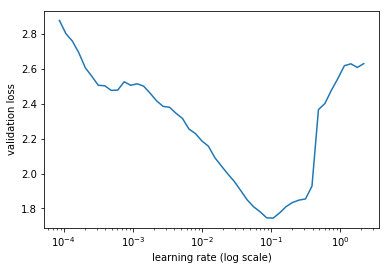

In [32]:
m0.sched.plot()

## Define the metric

Root mean squared logarithmic error

In [37]:
def exp_rmsle(y_pred, y):
    return math.sqrt( (((y_pred) - (y))**2).mean() )

## Train the model

Get new learner for fitting.

In [39]:
m1 = model.get_learner(emb_szs = embedding_sizes,
                       n_cont = len(cts_vars),
                       emb_drop = 0.04,
                       out_sz = 1,
                       szs = [1000, 500],
                       drops = [0.001, 0.01],
                       y_range = y_range)
lr = 1e-2

In [40]:
m1.fit(lr, n_cycle = 3, metrics = [exp_rmsle])

epoch      trn_loss   val_loss   exp_rmsle                 
    0      1.82555    0.243056   0.491258  
    1      0.558771   0.130572   0.359829                  
    2      0.269878   0.135061   0.365358                   



[array([0.13506]), 0.3653578587099011]

In [41]:
m1.fit(lr, n_cycle = 6, cycle_len = 1, metrics = [exp_rmsle])

epoch      trn_loss   val_loss   exp_rmsle                  
    0      0.274296   0.148918   0.38329   
    1      0.1772     0.127767   0.355489                   
    2      0.15224    0.128031   0.355407                   
    3      0.137056   0.130022   0.356599                   
    4      0.131813   0.135694   0.365429                   
    5      0.124734   0.13861    0.369101                   



[array([0.13861]), 0.36910066838648076]

## Predict using test set

In [44]:
yp, y = m1.predict_with_targs()

In [45]:
exp_rmsle(yp, y)

0.3723033265499303

In [46]:
pred = np.exp(m1.predict(is_test = True))

In [48]:
pred.shape

(6493, 1)

In [74]:
submission = test_set.copy()
submission['count'] = pred

In [77]:
submission['count'].head(5)

datetime
2011-01-20 00:00:00    6.598610
2011-01-20 01:00:00    5.370217
2011-01-20 02:00:00    2.997415
2011-01-20 03:00:00    2.026314
2011-01-20 04:00:00    1.747498
Name: count, dtype: float32

In [81]:
submission['count'].to_csv(f'submission-2018-08-24.csv', header = True, index = True)

Scored 0.41289 on public leaderboard. Previous best was 0.65837, which would have placed me 369 out of ~4000.